# COSP Diagnostics

We will look at some COSP output from CESM2. 

Data location will be on `glade/collections/`

Observations need to be staged somewhere.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xesmf as xe  # <-- xesmf is a nice wrapper for regridding; requires ESMpy

In [3]:
from pathlib import Path

In [4]:
# all the variables that come out of COSP (monthly),
# CAM NAME, CMIP NAME
cosp_master_list = [
    'CFAD_DBZE94_CS', #  , cfadDbze94
    'CFAD_SR532_CAL', #  , cfadLidarsr532
    'CLDHGH_CAL',     #  , clhcalipso
    'CLDHGH_CAL_ICE',
    'CLDHGH_CAL_LIQ',
    'CLDHGH_CAL_UN',
    'CLDLOW_CAL',     #  , cllcalipso
    'CLDLOW_CAL_ICE',
    'CLDLOW_CAL_LIQ',
    'CLDLOW_CAL_UN',
    'CLDMED_CAL',     #  , clmcalipso
    'CLDMED_CAL_ICE',
    'CLDMED_CAL_LIQ',
    'CLDMED_CAL_UN',
    'CLDTOT_CAL',     #  , cltcalipso
    'CLDTOT_CALCS',
    'CLDTOT_CAL_ICE',
    'CLDTOT_CAL_LIQ',
    'CLDTOT_CAL_UN',
    'CLDTOT_CS',
    'CLDTOT_CS2',
    'CLDTOT_ISCCP',   #  , cltisccp
    'CLD_CAL',        #  , clcalips
    'CLD_CAL_ICE',    #  , clcalipsoice
    'CLD_CAL_LIQ',    #  , clcalipsoliq
    'CLD_CAL_NOTCS',  #  , clcalipso2
    'CLD_CAL_UN',
    'CLD_MISR',       #  , clmisr
    'CLHMODIS',
    'CLIMODIS',       #  , climodis
    'CLLMODIS',
    'CLMMODIS',
    'CLMODIS',
    'CLRIMODIS',      #  , jpdftaureicemodis
    'CLRLMODIS',      #  , jpdftaureliqmodis
    'CLTMODIS',       #  , cltmodis
    'CLWMODIS',       #  , clwmodis
    'FISCCP1_COSP',   #  , clisccp
    'IWPMODIS',
    'LWPMODIS',
    'MEANCLDALB_ISCCP', #  , albisccp
    'MEANPTOP_ISCCP',   #  , pctisccp
    'MEANTAU_ISCCP',
    'MEANTBCLR_ISCCP',
    'MEANTB_ISCCP',
    'PCTMODIS',
    'REFFCLIMODIS',
    'REFFCLWMODIS',
    'RFL_PARASOL',     #  , parasolRefl
    'TAUILOGMODIS',
    'TAUIMODIS',
    'TAUTLOGMODIS',
    'TAUTMODIS',
    'TAUWLOGMODIS',
    'TAUWMODIS']

In [5]:
# MODEL DATA

# start with a single case:
data_loc = Path('/glade/collections/cdg/timeseries-cmip6')
case_name = 'f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001'
# '/glade/collections/cdg/timeseries-cmip6/f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001/atm/proc/tseries/month_1'
case_fils = sorted(list((data_loc / case_name / 'atm/proc/tseries/month_1').glob('*.nc')))
print(f"Found {len(case_fils)} files in this location.")

# build a dictionary:
# key: variable name
# value: list of time series files

cosp_dict = dict()
for v in cosp_master_list:
    cosp_var_fils = []
    for f in case_fils:
        fil_var = f.stem.split('.')[-2]
        if v == fil_var:
            cosp_var_fils.append(f)
        if len(cosp_var_fils) > 0:
            cosp_dict[v] = cosp_var_fils


Found 452 files in this location.


In [6]:
cosp_dict['CLDTOT_CAL']

[PosixPath('/glade/collections/cdg/timeseries-cmip6/f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001/atm/proc/tseries/month_1/f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001.cam.h0.CLDTOT_CAL.000101-003012.nc')]

In [7]:
def load_var(v, d):
    "Load the dataset that contains variable v from our dictionary of (variable, file) pairs."
    fils = d[v]
    if len(fils) == 1:
        return xr.open_dataset(fils[0], decode_times=False)
    else:
        return xr.open_dataset(fils, decode_times=False, combine='by_coords')

In [8]:
# start easy, let's look at CLDTOT in CLDTOT_CAL, CLTMODIS, CLDTOT_ISCCP
# (We can add MISR later)

ds_to_merge = [load_var(c, cosp_dict) for c in ['CLDTOT_CAL', 'CLTMODIS', 'CLDTOT_ISCCP']]
ds = xr.merge(ds_to_merge)
case_vars = {c: ds[c] for c in ['CLDTOT_CAL', 'CLTMODIS', 'CLDTOT_ISCCP']}
case_vars

{'CLDTOT_CAL': <xarray.DataArray 'CLDTOT_CAL' (time: 360, lat: 192, lon: 288)>
 [19906560 values with dtype=float32]
 Coordinates:
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time     (time) float64 31.0 59.0 90.0 ... 1.089e+04 1.092e+04 1.095e+04
 Attributes:
     units:         percent
     long_name:     Lidar Total Cloud Fraction
     cell_methods:  time: mean,
 'CLTMODIS': <xarray.DataArray 'CLTMODIS' (time: 360, lat: 192, lon: 288)>
 [19906560 values with dtype=float32]
 Coordinates:
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time     (time) float64 31.0 59.0 90.0 ... 1.089e+04 1.092e+04 1.095e+04
 Attributes:
     units:         %
     long_name:     MODIS Total Cloud Fraction
     cell_methods:  time: mean,
 'CLDTOT_ISCCP': <xarray.DataArr

In [9]:
# long-term mean
case_ltm = {c: case_vars[c].mean(dim='time') for c in case_vars}

In [29]:
# mapping tools

def _parse_kwargs(**kwargs):
    """Construct dict of non-Matplotlib options. Mutates kwargs, so be careful."""
    kw = {}
    if 'title' in kwargs:
        kw['set_title'] = True
        kw['title'] = kwargs.pop('title')
    else:
        kw['set_title'] = False
    if 'land' in kwargs:
        kw['set_land'] = True
    else:
        kw['set_land'] = False
    if 'cbtitle' in kwargs:
        kw['set_cb_title'] = True
        kw['cb_title'] = kwargs.pop('cbtitle')
    else:
        kw['set_cb_title'] = False
    if 'save' in kwargs:
        kw['set_save'] = True
        kw['save_name'] = kwargs.pop('save')
    else:
        kw['set_save'] = False  
    if 'cb_title' in kwargs:
        kw['set_cb_title'] = True
        kw['cb_title'] = kwargs.pop('cb_title')
    else:
        kw['set_cb_title'] = False
    if 'contours' in kwargs:
        kw['set_contours'] = True
        kw['contours'] = kwargs.pop('contours') # this should be data to contour /// how to set options?
    return kw


def _check_opt(d, k):
    return (k in d) and d[k]


def _apply_opts(inax, opts):
    if _check_opt(opts, "set_title"):
        inax.set_title(opts['title'],loc='left')
    if _check_opt(opts, "set_land"):
        inax.add_feature(cartopy.feature.LAND, zorder=100)

        
# maps of means
def mapper(data, **kwargs):
    local_opts = _parse_kwargs(**kwargs)
    lon = data['lon']
    lat = data['lat']
    data_wrap, lon_wrap = add_cyclic_point(data, coord=lon)
    wlons, wlats = np.meshgrid(lon_wrap, lat)
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
    img = ax.contourf(wlons, wlats, data_wrap, 
                              transform=ccrs.PlateCarree(), 
                              extend='both',
                              **kwargs)
    ax.coastlines()
 
    _apply_opts(ax, local_opts)
    
    cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=50)
    if _check_opt(local_opts, 'set_cb_title'):
        cbar.set_label(local_opts['cb_title'])
        
    if _check_opt(local_opts, 'set_save'):
        fig.savefig(local_opts['save_name'])
        
    return fig, ax



def diff_mapper(afld, bfld, **kwargs):
#     local_opts = _parse_kwargs(**kwargs) THIS IS THE WRONG CONTROL MECHANISM BECAUSE WILL INTERCEPT kwargs
    if 'contours' in kwargs:
        set_contour = True
        contour_data = kwargs.pop('contours')
    d = bfld - afld
    fig, ax = mapper(d, **kwargs)
    # add contour of some field:
    if set_contour:
        alon, alat = np.meshgrid(afld['lon'], afld['lat'])
        cp = ax.contour(alon, alat, contour_data, transform=ccrs.PlateCarree(), colors='gray')
    return fig, ax



(<Figure size 432x432 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b62efbcca20>)

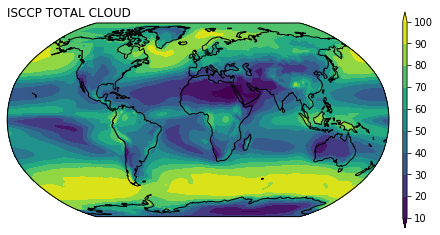

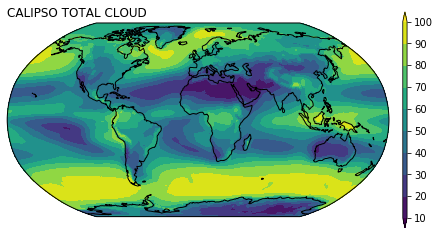

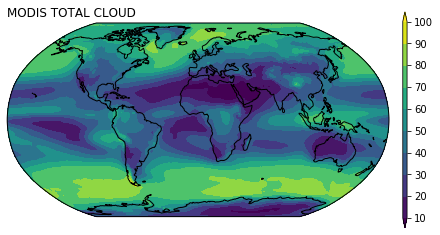

In [23]:
mapper(case_ltm['CLDTOT_ISCCP'], **{'title': 'ISCCP TOTAL CLOUD', 'levels':np.linspace(10, 100, 10)})
mapper(case_ltm['CLDTOT_CAL'], **{'title': 'CALIPSO TOTAL CLOUD', 'levels':np.linspace(10, 100, 10)})
mapper(case_ltm['CLTMODIS'], **{'title': 'MODIS TOTAL CLOUD', 'levels':np.linspace(10, 100, 10)})

In [24]:
_check_opt({"one":True, "two":False}, "three")

False

In [25]:
# now let's start doing something.
# Get the CALIPSO data and compare long-term means
# I regridded these on cgdm-bespin using ncremap and ncrename; took about a minute after a couple of hours fighting with casper and ESMF
ds_obs = xr.open_mfdataset("/glade/work/brianpm/observations/clcalipso/regridded/f09_MapLowMidHigh330m_*.nc", combine='by_coords')
# could automate this by trimming: 
obs_avg = ds_obs['cllcalipso'].sel(time=slice('2007-01-01', '2017-12-31')).mean(dim='time')

print(obs_avg)


<xarray.DataArray 'cllcalipso' (lat: 192, lon: 288)>
dask.array<shape=(192, 288), dtype=float32, chunksize=(192, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'title'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


(<Figure size 432x432 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b62ef890710>)

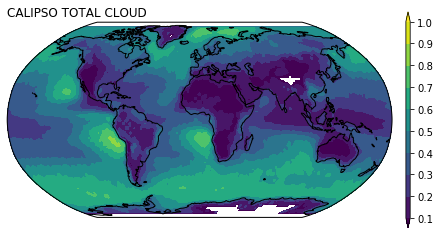

In [26]:
mapper(obs_avg, **{'title': 'CALIPSO TOTAL CLOUD', 'levels':np.linspace(.10, 1.00, 10)})

/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'title'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


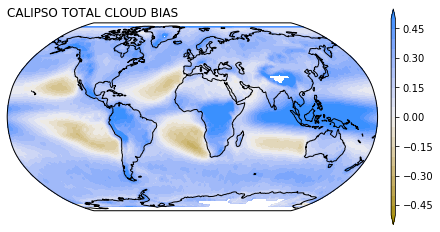

In [31]:
fig01, ax01 = mapper(case_ltm['CLDTOT_CAL']*0.01 - obs_avg, **{'title': 'CALIPSO TOTAL CLOUD BIAS', 'levels':np.linspace(-.5, .5, 21), 'cmap':cc.cm.bwy_r})

/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'title'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/home/brianpm/miniconda/envs/forge/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


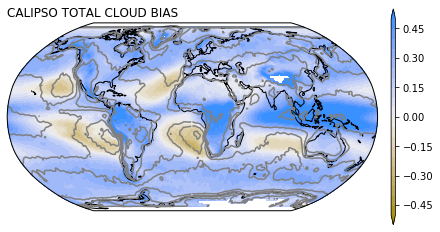

In [32]:

fig01, ax01 = diff_mapper(obs_avg, case_ltm['CLDTOT_CAL']*0.01, **{'title': 'CALIPSO TOTAL CLOUD BIAS', 'levels':np.linspace(-.5, .5, 21), 'cmap':cc.cm.bwy_r, 'contours':obs_avg})

In [36]:
# let's start to look at ISCCP histograms:
ds2 = load_var("FISCCP1_COSP", cosp_dict)


In [44]:

ds2['time'].values = ds2['time_bnds'].mean(dim='nbnd')
ds2 = xr.decode_cf(ds2)

In [49]:
# m_isccp # xarray.DataArray 'FISCCP1_COSP' (time: 360, cosp_prs: 7, cosp_tau: 7, lat: 192, lon: 288)
m_isccp = ds2['FISCCP1_COSP']
# It doesn't really make a lot of sense to average over everything, so let's start with just the KH Box:
# Californian 20-30, 120W-130W
sc_california = m_isccp.sel(lat=slice(20.,30.), lon=slice(360-130, 360-120)) # <xarray.DataArray 'FISCCP1_COSP' (time: 360, cosp_prs: 7, cosp_tau: 7, lat: 11, lon: 9)>

sc_cal_seas = sc_california.groupby('time.season').mean(dim='time')
sc_cal_seas_avg = sc_cal_seas.mean(dim=('lat', 'lon'))
sc_cal_seas_avg

<xarray.DataArray 'FISCCP1_COSP' (season: 4, cosp_prs: 7, cosp_tau: 7)>
array([[[7.231067e-02, 1.541764e-01, 2.421413e+00, 2.815443e+00,
         2.018086e+00, 2.227298e-01, 0.000000e+00],
        [2.185347e-01, 9.332836e-02, 1.842359e+00, 4.980256e+00,
         4.327449e+00, 6.267421e-01, 7.645528e-04],
        [1.511182e-01, 3.202408e-02, 3.869607e-01, 1.389818e+00,
         1.630068e+00, 3.494336e-01, 4.705803e-03],
        [4.491277e-01, 1.693893e-01, 3.345747e-01, 1.146825e+00,
         1.060925e+00, 2.648760e-01, 1.621082e-02],
        [2.560717e+00, 2.250159e+00, 1.583549e+00, 1.422047e+00,
         1.134933e+00, 2.804162e-01, 3.495454e-03],
        [7.908132e+00, 4.668862e+00, 1.746282e+00, 4.382113e-01,
         3.154849e-01, 5.806224e-02, 8.521565e-05],
        [3.989782e+00, 5.525091e-01, 5.039579e-02, 8.460519e-03,
         1.206811e-05, 0.000000e+00, 0.000000e+00]],

       [[1.835767e-02, 1.120779e-01, 2.476835e+00, 3.957762e+00,
         3.219365e+00, 5.424967e-01, 5.519

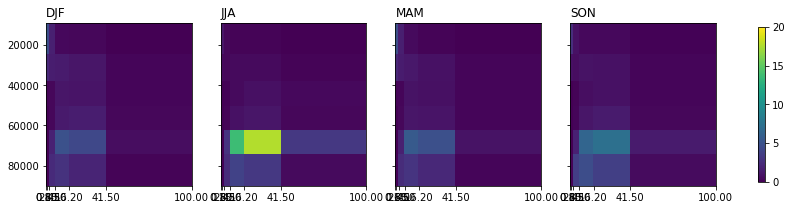

In [64]:
figISCCP, axISCCP = plt.subplots(ncols=4, figsize=(15, 3), sharey=True)
tau, prs = np.meshgrid(ds2['cosp_tau'], ds2['cosp_prs'])
img = [axISCCP[i].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season=s), vmin=0, vmax=20) for i,s in enumerate(sc_cal_seas_avg['season'])]
[axISCCP[i].set_title(s.values, loc='left') for i,s in enumerate(sc_cal_seas_avg['season'])]
# axISCCP[0].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='JJA'))
# axISCCP[1].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='SON'))
# axISCCP[2].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='DJF'))
# axISCCP[3].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='MAM'))
[a.set_xticks(ds2['cosp_tau'].values) for a in axISCCP]
axISCCP[-1].invert_yaxis()
cbISCCP = figISCCP.colorbar(img[0], ax=axISCCP.ravel().tolist(), shrink=0.95)
# I think this is right, ==> next cell seems to confirm ... 
# BUT this stretches the cells to make the scale linear

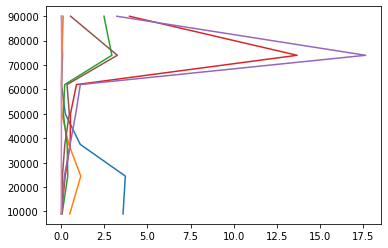

In [70]:
plt.plot(sc_cal_seas_avg.sel(season='JJA'), ds2['cosp_prs'], )

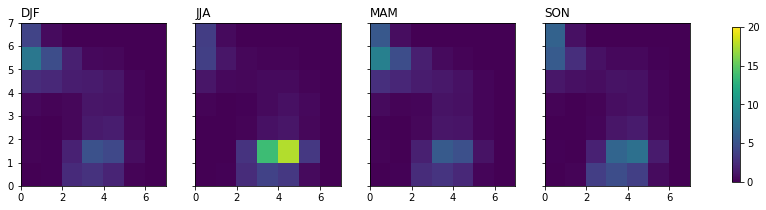

In [73]:
figISCCP, axISCCP = plt.subplots(ncols=4, figsize=(15, 3), sharey=True)
img = [axISCCP[i].pcolormesh(sc_cal_seas_avg.sel(season=s), vmin=0, vmax=20) for i,s in enumerate(sc_cal_seas_avg['season'])]
[axISCCP[i].set_title(s.values, loc='left') for i,s in enumerate(sc_cal_seas_avg['season'])]
# axISCCP[0].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='JJA'))
# axISCCP[1].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='SON'))
# axISCCP[2].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='DJF'))
# axISCCP[3].pcolormesh(tau, prs, sc_cal_seas_avg.sel(season='MAM'))
# [a.set_xtick(ds2['cosp_tau'].values) for a in axISCCP]
# axISCCP[-1].invert_yaxis()
cbISCCP = figISCCP.colorbar(img[0], ax=axISCCP.ravel().tolist(), shrink=0.95)

In [13]:
heights, lats = np.meshgrid(ds032['cosp_ht'][::-1], ds032['lat'])

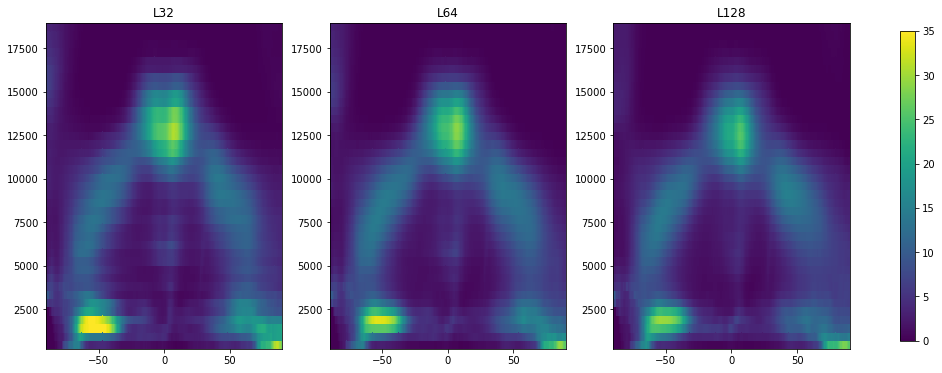

In [139]:
n = 3
datalist = {"L32": c32_avg, "L64":c64_avg, "L128": c128_avg}
fig, ax = plt.subplots(ncols=n, figsize=(n*6,6))
imgs = [ax[i].pcolormesh(lats, heights, datalist[v].transpose(), vmin=0, vmax=35) for i, v in enumerate(datalist)]
[ax[i].set_title(v) for i, v in enumerate(datalist.keys())]
cbar = fig.colorbar(imgs[0], ax=ax.ravel().tolist(), shrink=0.95)

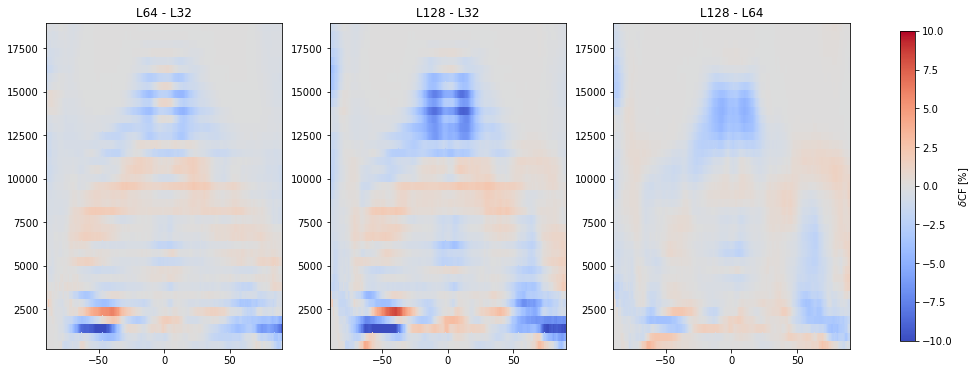

In [141]:
n = 3
datalist = {"L64 - L32": c64_avg - c32_avg, "L128 - L32":c128_avg - c32_avg, "L128 - L64": c128_avg - c64_avg}
fig, ax = plt.subplots(ncols=n, figsize=(n*6,6))
imgs = [ax[i].pcolormesh(lats, heights, datalist[v].transpose(), vmin=-10, vmax=10, cmap="coolwarm") for i, v in enumerate(datalist)]
[ax[i].set_title(v) for i, v in enumerate(datalist.keys())]
cbar = fig.colorbar(imgs[0], ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label("$\delta$CF [%]")


In [146]:
# SOURCE: http://climserv.ipsl.polytechnique.fr/cfmip-obs/
# SOURCE: ftp://ftp.climserv.ipsl.polytechnique.fr/cfmip/GOCCP_v3/2D_Maps/grid_2x2xL40/

# USED TO GET THE CALIPSO FILES FROM THE FTP SITE (mounted via Finder)
# from pathlib import Path
# import shutil
# p = Path("/Volumes/grid_2x2xL40/")
# calipso_fils = list(p.rglob('2*/avg/3D_CloudFraction330m_*_avg_CFMIP2_sat_3.1.2.nc'))
# for f in calipso_fils:
#     shutil.copy(f, "/Users/brianpm/Documents/clcalipso/")


# # 2D fields: cllcalipso, clmcalipso, clhcalipso, cltcalipso, clccalipso
# from pathlib import Path
# import shutil
# p = Path("/Volumes/grid_2x2xL40-1/")
# calipso_fils = list(p.rglob('2*/avg/MapLowMidHigh330m_*_avg_CFMIP2_sat_3.1.2.nc'))
# for f in calipso_fils:
#     shutil.copy(f, "/Users/brianpm/Documents/clcalipso/")

In [26]:
ds_obs = xr.open_mfdataset("/Users/brianpm/Documents/clcalipso/*.nc", combine='by_coords')

In [39]:
ds_obs

<xarray.Dataset>
Dimensions:     (altitude: 40, latitude: 90, longitude: 180, nv: 2, time: 140)
Coordinates:
  * longitude   (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude    (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time        (time) datetime64[ns] 2006-06-21T18:00:00 ... 2018-03-16
Dimensions without coordinates: altitude, nv
Data variables:
    alt_mid     (time, altitude) float32 dask.array<shape=(140, 40), chunksize=(1, 40)>
    alt_bound   (time, nv, altitude) float32 dask.array<shape=(140, 2, 40), chunksize=(1, 2, 40)>
    clcalipso   (time, altitude, latitude, longitude) float32 dask.array<shape=(140, 40, 90, 180), chunksize=(1, 40, 90, 180)>
    clrcalipso  (time, altitude, latitude, longitude) float32 dask.array<shape=(140, 40, 90, 180), chunksize=(1, 40, 90, 180)>
    uncalipso   (time, altitude, latitude, longitude) float32 dask.array<shape=(140, 40, 90, 180), chunksize=(1, 40, 90, 180)>
Attributes:
    Description:     

In [38]:
obs_avg = ds_obs['clcalipso'].sel(time=slice('2007-01-01', '2017-12-31')).mean(dim='time').mean(dim='longitude')

In [49]:
olat = ds_obs['latitude']

/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


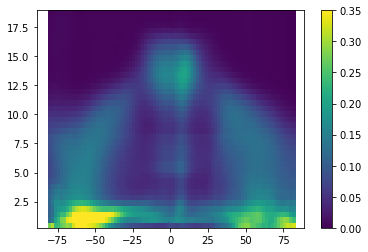

In [47]:
f3, a3 = plt.subplots()
oht, olat = np.meshgrid(ds_obs['alt_mid'][0,:], ds_obs['latitude'])
img3 = a3.pcolormesh(olat, oht, obs_avg.transpose(), vmin=0, vmax=.35)
f3.colorbar(img3)

In [57]:
import scipy.interpolate as interp

In [80]:
# have to regrid to take difference
obs_nonan = obs_avg.sel(latitude=slice(-80, 80))
obs_interp = np.zeros([40, len(lat)])
interp_func = interp.interp1d(obs_nonan['latitude'].values, obs_nonan.values, kind='linear', axis=1, bounds_error=False)
# for lev in range(40):
# #     obs_interp[lev, :] = np.interp(lat.values, olat.values, obs_avg[lev,:].values)
#     obs_interp[lev, :] = interp_func(lat)

obs_interp = interp_func(lat)

/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


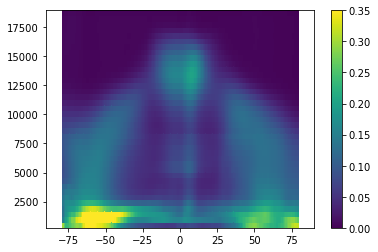

In [99]:
f4, a4 = plt.subplots()
img4 = a4.pcolormesh(lats, heights, obs_interp.transpose(), vmin=0, vmax=.35)
f4.colorbar(img4)

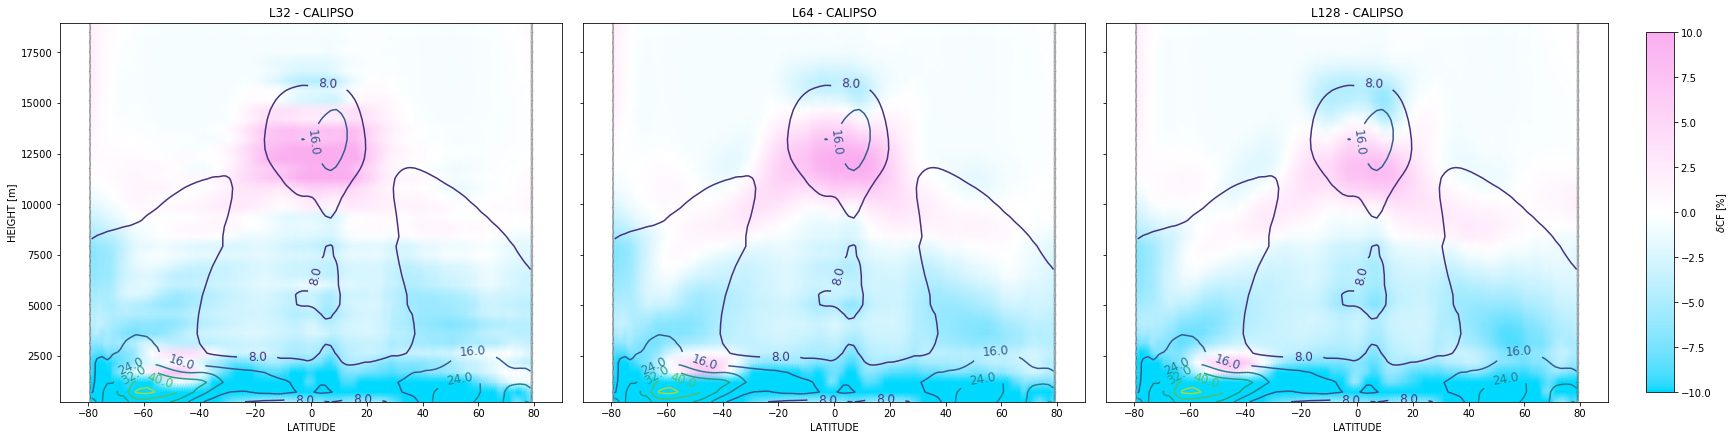

In [142]:
# THE DIFFERENCE PLOT:
f5, a5 = plt.subplots(ncols=3, figsize=(24,6), sharey=True, constrained_layout=True)
img5a = a5[0].pcolormesh(lats, heights, c32_avg.transpose() - (obs_interp*100).transpose(), vmin=-10, vmax=10, cmap=cc.cm.CET_D10, shading='gouraud')
img5b = a5[1].pcolormesh(lats, heights, c64_avg.transpose() - (obs_interp*100).transpose(), vmin=-10, vmax=10, cmap=cc.cm.CET_D10, shading='gouraud')
img5c = a5[2].pcolormesh(lats, heights, c128_avg.transpose() - (obs_interp*100).transpose(), vmin=-10, vmax=10, cmap=cc.cm.CET_D10, shading='gouraud')


# cntr = a5[0].contour(lats, heights, (obs_interp*100).transpose())
# cntr2 = a5[1].contour(lats, heights, (obs_interp*100).transpose())
# cntr3 = a5[2].contour(lats, heights, (obs_interp*100).transpose())


cntr = [a5[i].contour(lats, heights, (obs_interp*100).transpose()) for i, v in enumerate(a5)]
[v.clabel(cntr[i], inline=1, fontsize=12, fmt='%1.1f') for i, v in enumerate(a5)]


a5[0].set_title("L32 - CALIPSO")
a5[1].set_title("L64 - CALIPSO")
a5[2].set_title("L128 - CALIPSO")


a5[0].set_ylabel("HEIGHT [m]")
a5[0].set_xlabel("LATITUDE")
a5[1].set_xlabel("LATITUDE")
a5[2].set_xlabel("LATITUDE")


cbar = f5.colorbar(img5a, ax=a5.ravel().tolist(), shrink=0.95, aspect=50)
cbar.set_label("$\delta$CF [%]")
f5.savefig("/Users/brianpm/Desktop/vres_calipso_v1.png")

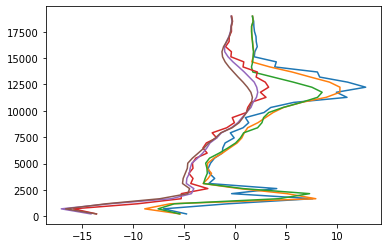

In [145]:
mxer32 = (c32_avg.transpose() - (obs_interp*100).transpose()).max(dim='lat')
mxer64 = (c64_avg.transpose() - (obs_interp*100).transpose()).max(dim='lat')
mxer128 = (c128_avg.transpose() - (obs_interp*100).transpose()).max(dim='lat')

plt.plot(mxer32, ds032['cosp_ht'][::-1], mxer64, ds064['cosp_ht'][::-1], mxer128 , ds128['cosp_ht'][::-1])

aver32 = (c32_avg.transpose() - (obs_interp*100).transpose()).mean(dim='lat')
aver64 = (c64_avg.transpose() - (obs_interp*100).transpose()).mean(dim='lat')
aver128 = (c128_avg.transpose() - (obs_interp*100).transpose()).mean(dim='lat')

plt.plot(aver32, ds032['cosp_ht'][::-1], aver64, ds064['cosp_ht'][::-1], aver128 , ds128['cosp_ht'][::-1])

# MAPS
Now we use the 2D fields to get a sense for the spatial patterns.

In [147]:
# observation
calipso_2d_ds = xr.open_mfdataset("/Users/brianpm/Documents/clcalipso/MapLowMidHigh330m_*_avg_CFMIP2_sat_3.1.2.nc", combine='by_coords')

In [150]:
cllcalipso = calipso_2d_ds['cllcalipso']
cllcalipso_climo = cllcalipso.groupby('time.month').mean(dim='time')
cllcalipso_climo

<xarray.DataArray 'cllcalipso' (month: 12, latitude: 90, longitude: 180)>
dask.array<shape=(12, 90, 180), dtype=float32, chunksize=(1, 90, 180)>
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [164]:
cllcalipso_seas = cllcalipso.groupby("time.season").mean(dim='time')

In [152]:
cal_lons, cal_lats = np.meshgrid(calipso_2d_ds['longitude'], calipso_2d_ds['latitude'])

/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x

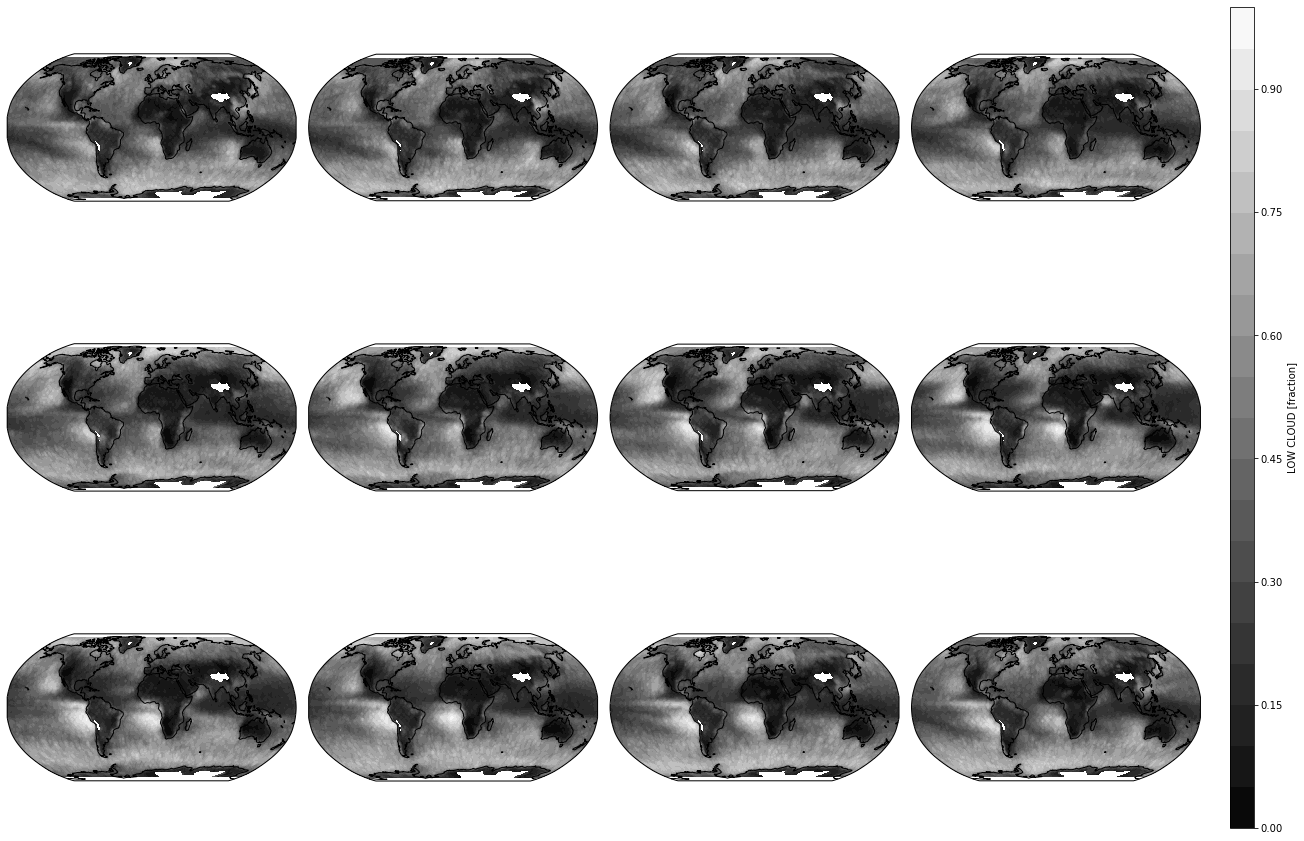

In [163]:
f6, a6 = plt.subplots(figsize=(18,12), ncols=4, nrows=3, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a6.flat[i].contourf(cal_lons, cal_lats, cllcalipso_climo.isel(month=i), levels=np.linspace(0, 1, 21), cmap=cc.cm.gray, transform=ccrs.PlateCarree()) for i in range(12)]
[a6.flat[i].coastlines() for i in range(12)]
cbar = f6.colorbar(imgs[0], ax=a6.ravel().tolist(), shrink=0.95, aspect=50)
cbar.set_label("LOW CLOUD [fraction]")

/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


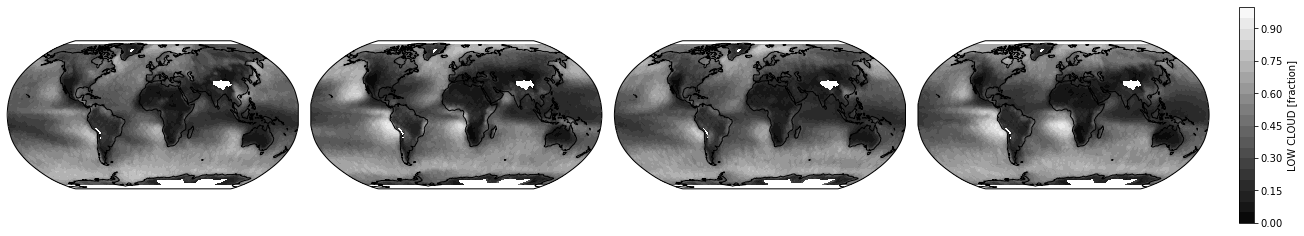

In [166]:
# Seasonal
f7, a7 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a7.flat[i].contourf(cal_lons, cal_lats, cllcalipso_seas.isel(season=i), levels=np.linspace(0, 1, 21), cmap=cc.cm.gray, transform=ccrs.PlateCarree()) for i in range(len(cllcalipso_seas['season']))]
[a7.flat[i].coastlines() for i in range(len(cllcalipso_seas['season']))]
cbar = f7.colorbar(imgs[0], ax=a7.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("LOW CLOUD [fraction]")

In [167]:
def load_cesm_ds(filname):
    ds = xr.open_dataset(filname, decode_times=False)
    tb = ds['time_bnds']
    new_time = tb.mean(dim='nbnd')
    ds['time'].values = new_time
    ds = xr.decode_cf(ds)
    return ds

In [168]:
# Let's do seasonal for the models:
l032_cal2 = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L032.2DCLD_CAL.ncrcat.nc")
l064_cal2 = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L064.2DCLD_CAL.ncrcat.nc")
l128_cal2 = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L128.2DCLD_CAL.ncrcat.nc")

l032_cllcalipso_seas = l032_cal2['CLDLOW_CAL'].groupby("time.season").mean(dim='time')
l064_cllcalipso_seas = l064_cal2['CLDLOW_CAL'].groupby("time.season").mean(dim='time')
l128_cllcalipso_seas = l128_cal2['CLDLOW_CAL'].groupby("time.season").mean(dim='time')

/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [259]:
cesm_lat = l032_cal2['lat']
cesm_lon = l032_cal2['lon']

In [169]:
lons, lats = np.meshgrid(l032_cal2['lon'], l032_cal2['lat'])

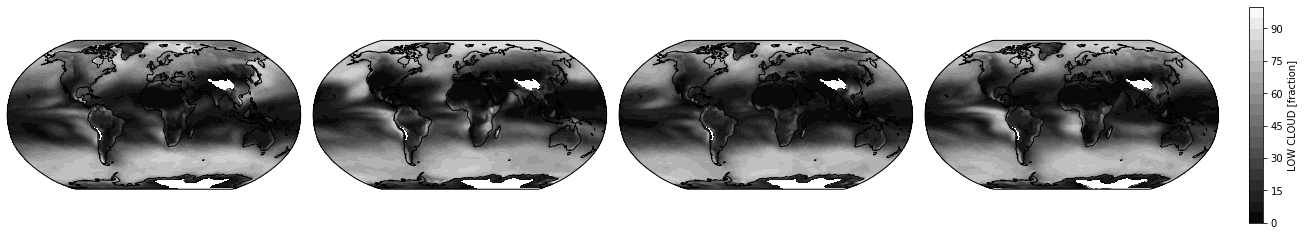

In [171]:
# Seasonal
f8, a8 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a8.flat[i].contourf(lons, lats, l032_cllcalipso_seas.isel(season=i), levels=np.linspace(0, 100, 21), cmap=cc.cm.gray, transform=ccrs.PlateCarree()) for i in range(4)]
[a8.flat[i].coastlines() for i in range(4)]
cbar = f8.colorbar(imgs[0], ax=a8.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("LOW CLOUD [fraction]")

In [280]:
# let's try 2d interpolation with scipy ... BUT NOTE THAT WE NEED TO SHIFT LONGIUTDES
nlon = len(cllcalipso_seas['longitude'])
new_lon = (cllcalipso_seas['longitude'] + 360) % 360
# change the coordinate values and roll the data to get 1-360:
cllcalipso_seas_roll = cllcalipso_seas.copy(deep=True)
cllcalipso_seas_roll = cllcalipso_seas_roll.assign_coords(longitude=new_lon)
cllcalipso_seas_roll = cllcalipso_seas_roll.roll(longitude=nlon//2, roll_coords=True)

# for sanity, let's rename the coordinates:
cllcalipso_seas_roll = cllcalipso_seas_roll.rename({"latitude":"lat", "longitude":"lon"})

# cllcalipso_seas['longitude']
# cllcalipso_seas['latitude']
# cllcalipso_seas
print(cllcalipso_seas_roll['season'])

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'


In [277]:
grid_out = xr.Dataset({'lat': cesm_lat, 'lon': cesm_lon})
regridder = xe.Regridder(cllcalipso_seas_roll, grid_out, 'bilinear', periodic=True)
print(regridder)
cllcalipso_seas_intrp2 = regridder(cllcalipso_seas_roll)

Create weight file: bilinear_90x180_192x288_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_90x180_192x288_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (192, 288) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


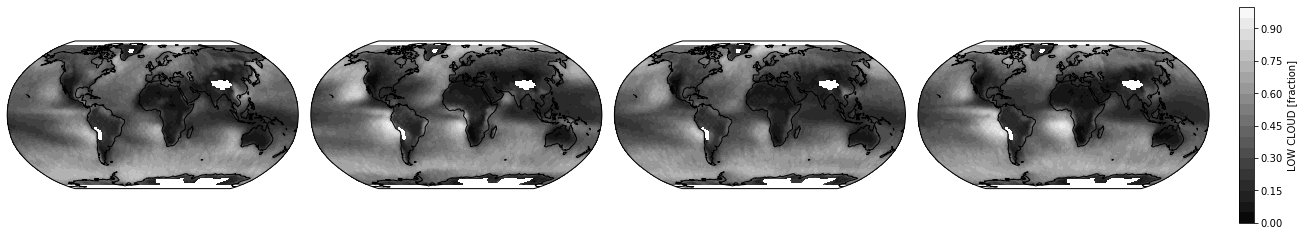

In [278]:
# Seasonal
f9, a9 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a9.flat[i].contourf(lons, lats, cllcalipso_seas_intrp2.isel(season=i), levels=np.linspace(0, 1, 21), cmap=cc.cm.gray, transform=ccrs.PlateCarree()) for i in range(4)]
[a9.flat[i].coastlines() for i in range(4)]
cbar = f9.colorbar(imgs[0], ax=a9.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("LOW CLOUD [fraction]")

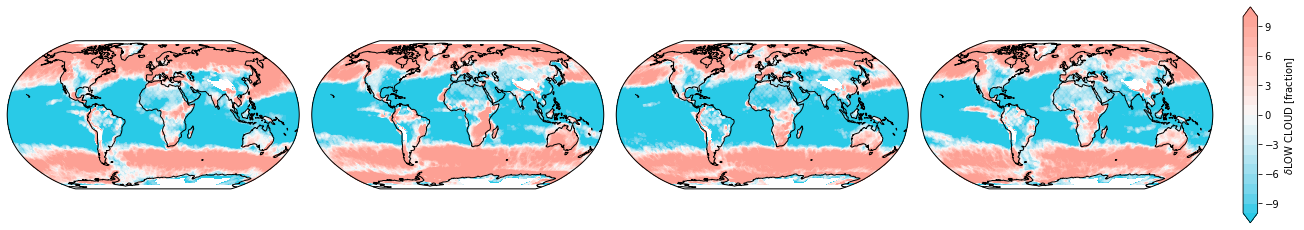

In [279]:
# Seasonal Bias L32
delx = l032_cllcalipso_seas - 100.*cllcalipso_seas_intrp2
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-10, 10, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]
cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$LOW CLOUD [fraction]")

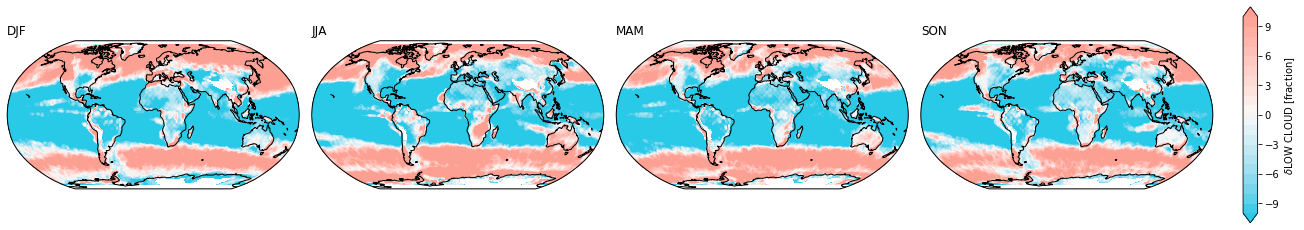

In [283]:
# Seasonal Bias L64
delx = l064_cllcalipso_seas - 100.*cllcalipso_seas_intrp2
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-10, 10, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]

[a10.flat[i].set_title(cllcalipso_seas_roll['season'][i].values,loc='left') for i in range(4)]

cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$LOW CLOUD [fraction]")

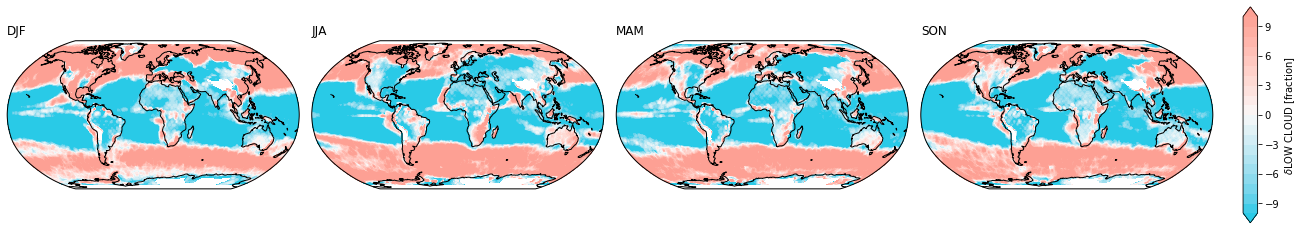

In [284]:
# Seasonal Bias L128
delx = l128_cllcalipso_seas - 100.*cllcalipso_seas_intrp2
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-10, 10, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]

[a10.flat[i].set_title(cllcalipso_seas_roll['season'][i].values,loc='left') for i in range(4)]

cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$LOW CLOUD [fraction]")

In [288]:
cllcalipso_seas_roll.max().values

/Users/brianpm/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(0.9420735, dtype=float32)

In [290]:
misr_ds = xr.open_mfdataset("/Users/brianpm/Documents/clmisr/clMISR_obs4MIPS_MISR_L3_V6_*.nc.gz", combine='by_coords')

In [315]:
clmisr = misr_ds['clMISR']

In [294]:
l032_misr_ds = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L032.CLD_MISR.ncrcat.nc")
l064_misr_ds = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L064.CLD_MISR.ncrcat.nc")
l128_misr_ds = load_cesm_ds("/Users/brianpm/Dropbox/Data/vres_L128.CLD_MISR.ncrcat.nc")

l032_misr = l032_misr_ds['CLD_MISR']
l064_misr = l064_misr_ds['CLD_MISR']
l128_misr = l128_misr_ds['CLD_MISR']



In [328]:
# dim_sum_Wrap(dim_sum_Wrap(clmisr(lat|:,lon|:,{misr_cth|0:3},{misr_tau|0.3:})))
# so sum over heights that are 0-3km and tau greater than 0.3
cllmisr = (clmisr/100.0).sel(cth=slice(0,3000), tau=slice(0.3,None)).sum(dim=('cth', 'tau'))
l032_cllmisr = (l032_misr/100.0).sel(cosp_htmisr=slice(0,3000), cosp_tau=slice(0.3,None)).sum(dim=('cosp_htmisr', 'cosp_tau'))
l064_cllmisr = (l064_misr/100.0).sel(cosp_htmisr=slice(0,3000), cosp_tau=slice(0.3,None)).sum(dim=('cosp_htmisr', 'cosp_tau'))
l128_cllmisr = (l128_misr/100.0).sel(cosp_htmisr=slice(0,3000), cosp_tau=slice(0.3,None)).sum(dim=('cosp_htmisr', 'cosp_tau'))

In [330]:
# regrid cllmisr to CAM grid
# (test if we need to roll lon)
# same as before: grid_out = xr.Dataset({'lat': cesm_lat, 'lon': cesm_lon})
misr_regridder = xe.Regridder(cllmisr, grid_out, 'bilinear', periodic=True)
print(misr_regridder)
cllmisr_intrp = misr_regridder(cllmisr)


Create weight file: bilinear_180x360_192x288_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_180x360_192x288_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (192, 288) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


<xarray.DataArray 'clMISR' (time: 156, lat: 192, lon: 288)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) datetime64[ns] 2000-07-01 2000-08-01 ... 2013-06-01
Attributes:
    regrid_method:  bilinear

In [303]:
def plt_misr_hist(x, height='cosp_htmisr', tau='cosp_tau'):
    fig, ax = plt.subplots()
    mtau, mheight = np.meshgrid(x[tau], x[height])
    img = ax.pcolormesh(mtau, mheight, x, cmap=cc.cm.CET_CBTL2_r, vmin=0, vmax=30)
    cbar = fig.colorbar(img, ax=ax, shrink=0.5)
    return fig, ax

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3edebd4e0>)

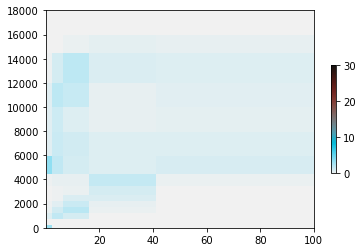

In [304]:
plt_misr_hist(l128_misr.sel(lat=10, lon=180, method='nearest').mean(dim='time'))

In [331]:
# 
cllmisr_season = cllmisr_intrp.groupby('time.season').mean(dim='time')
l032_cllmisr_season = l032_cllmisr.groupby('time.season').mean(dim='time')
l064_cllmisr_season = l064_cllmisr.groupby('time.season').mean(dim='time')
l128_cllmisr_season = l128_cllmisr.groupby('time.season').mean(dim='time')

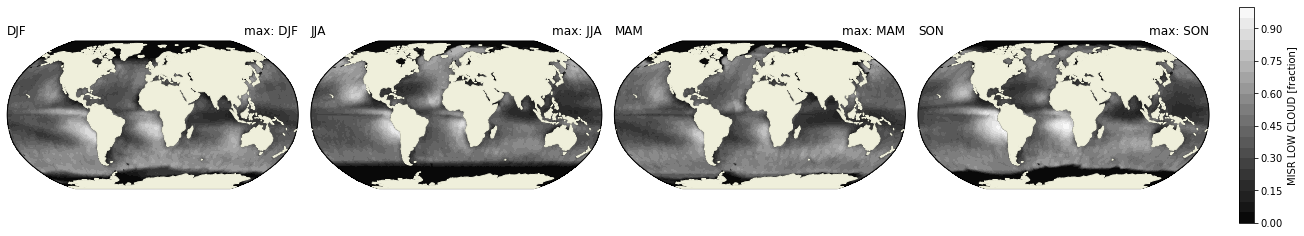

In [347]:
# Seasonal
f9, a9 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a9.flat[i].contourf(lons, lats, cllmisr_season.isel(season=i), levels=np.linspace(0, 1, 21), cmap=cc.cm.gray, transform=ccrs.PlateCarree()) for i in range(4)]
[a9.flat[i].coastlines() for i in range(4)]
[a9.flat[i].set_title(cllmisr_season['season'][i].values, loc='left') for i in range(4)]
[a9.flat[i].set_title(f"max: {np.asscalar(cllmisr_season['season'][i].max().values)}", loc='right') for i in range(4)]
[a9.flat[i].add_feature(cartopy.feature.LAND, zorder=100) for i in range(4)]


cbar = f9.colorbar(imgs[0], ax=a9.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("MISR LOW CLOUD [fraction]")

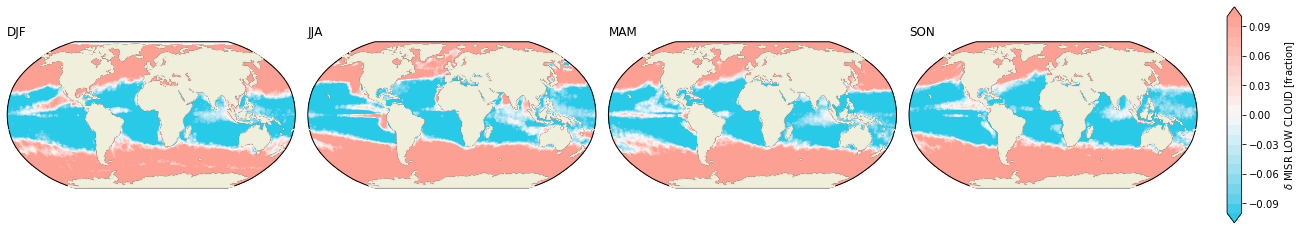

In [339]:
# Seasonal Bias L128
delx = l128_cllmisr_season - cllmisr_season
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-.10, .10, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]

[a10.flat[i].set_title(cllcalipso_seas_roll['season'][i].values,loc='left') for i in range(4)]
[a10.flat[i].add_feature(cartopy.feature.LAND, zorder=100) for i in range(4)]


cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$ MISR LOW CLOUD [fraction]")

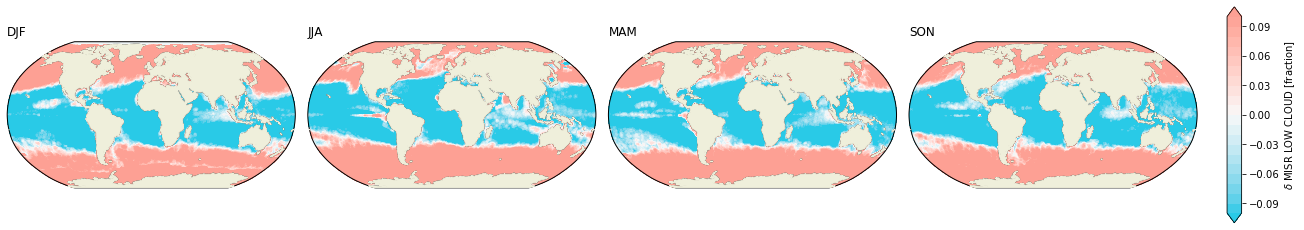

In [344]:
# Seasonal Bias L064
delx = l064_cllmisr_season - cllmisr_season
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-.10, .10, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]

[a10.flat[i].set_title(cllcalipso_seas_roll['season'][i].values,loc='left') for i in range(4)]
[a10.flat[i].add_feature(cartopy.feature.LAND, zorder=100) for i in range(4)]


cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$ MISR LOW CLOUD [fraction]")

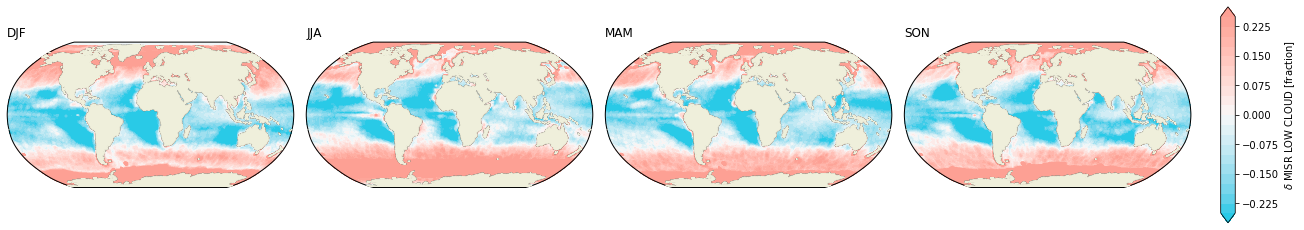

In [346]:
# Seasonal Bias L032
delx = l032_cllmisr_season - cllmisr_season
data_wrap, lon_wrap = add_cyclic_point(delx, coord=cesm_lon)
wlons, wlats = np.meshgrid(lon_wrap, cesm_lat)
f10, a10 = plt.subplots(figsize=(18,4), ncols=4, subplot_kw={"projection":ccrs.Robinson()}, constrained_layout=True)
imgs = [a10.flat[i].contourf(wlons, wlats, data_wrap[i,:,:], 
                             levels=np.linspace(-.25, .25, 21), cmap=cc.cm.cwr, transform=ccrs.PlateCarree(), extend='both') for i in range(4)]
[a10.flat[i].coastlines() for i in range(4)]

[a10.flat[i].set_title(cllcalipso_seas_roll['season'][i].values,loc='left') for i in range(4)]
[a10.flat[i].add_feature(cartopy.feature.LAND, zorder=100) for i in range(4)]


cbar = f10.colorbar(imgs[0], ax=a10.ravel().tolist(), shrink=0.75, aspect=50)
cbar.set_label("$\delta$ MISR LOW CLOUD [fraction]")

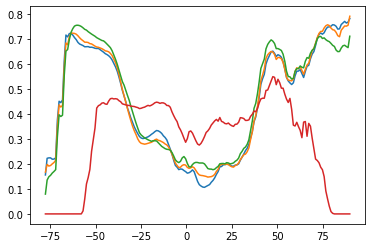

In [361]:
a = l032_cllmisr_season.where(LAND < 0.01).sel(season="JJA").mean(dim='lon')
b = l064_cllmisr_season.where(LAND < 0.01).sel(season="JJA").mean(dim='lon')
c = l128_cllmisr_season.where(LAND < 0.01).sel(season="JJA").mean(dim='lon')
d = cllmisr_season.where(LAND < 0.01).sel(season="JJA").mean(dim='lon')



plt.plot(cesm_lat, a,       
         cesm_lat, b,
         cesm_lat, c,
         cesm_lat, d)

In [357]:
LAND_ds = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
LAND = LAND_ds['LANDFRAC'].squeeze()

In [359]:
a = l032_cllmisr_season.where(LAND < 0.01).sel(season="JJA").mean(dim='lon')

/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [360]:
a

<xarray.DataArray 'CLD_MISR' (lat: 192)>
array([     nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan, 0.156166,
       0.222938, 0.224611, 0.224682, 0.219248, 0.219643, 0.224768, 0.376072,
       0.4516  , 0.446046, 0.456578, 0.611919, 0.716847, 0.709542, 0.723039,
       0.722776, 0.716853, 0.706748, 0.698705, 0.687486, 0.680942, 0.677653,
       0.674607, 0.669891, 0.670295, 0.670543, 0.667907, 0.668232, 0.666584,
       0.663797, 0.662942, 0.663277, 0.658325, 0.653281, 0.648241, 0.642252,
       0.638597, 0.633937, 0.627094, 0.617251, 0.60351 , 0.589254, 0.571996,
       0.548906, 0.523186, 0.495074, 0.473154, 0.450033, 0.424067, 0.404991,
       0.383749, 0.366354, 0.348374, 0.33443 , 0.321549, 0.310183, 0.304242,
       0.301926, 0.303308, 0.305993, 0.308958, 0.313362, 0.319019, 0.323708,
       0.329679, 0.33425 , 0.332899, 0.328808, 0.322693, 0.312993, 0.306307,
       0.296511, 0.278619, 0.259818

In [ ]:
# 
